In [1]:
import sys
sys.path.append("scripts/")
from Robot import*

In [2]:
class Agent2Goal(Agent):    #Agentクラスから継承し，新たなエージェントを定義
        def __init__(self, goal_pos=[0, 0]):
            super().__init__()    #親クラスから継承
            self.goal_pos = goal_pos    #ゴール座標

        def action(self, pose):    #actionメソッドをオーバーライド
            kp = 0.01    #比例ゲイン
            direction = math.atan2(self.goal_pos[1] - pose[1], self.goal_pos[0] - pose[0])*180/math.pi    #ゴールの方角
            rover_dir = pose[2]*180/math.pi    #ローバーの向いている方角
            deltaTheta = ((540 + direction - rover_dir) % 360) - 180    #ローバーの向いている方角とゴールの向いている方角の差
            mPF = 10    #モータ前進成分
            mPS = kp * deltaTheta    #モータ回転成分
            mPL = mPF - mPS    #左モータパワー
            mPR = mPF + mPS    #右モータパワー
            
            #モータパワーの絶対値をを100以下にする
            #エージェントクラスにも同じ処理が実装されているが，それは制約を実装したもの
            #下のコードは誤った入力による事故を防止するための実装
            mPL = 100 if mPL > 100 else mPL
            mPR = 100 if mPR > 100 else mPR
            mPL = -100 if mPL < -100 else mPL
            mPR = -100 if mPR < -100 else mPR
            
            self.motor(mPL, mPR)    #モータの駆動（ローバーの移動速度が自動的に計算される）
            return self.nu, self.omega    #ローバーの移動速度を返す

<IPython.core.display.Javascript object>


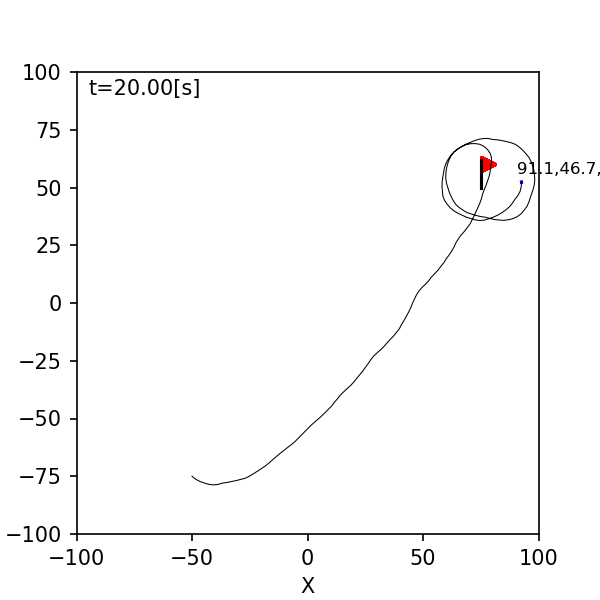

In [3]:
if __name__ == "__main__":    #ライブラリとして読み込む場合は実行しない  
    time_finish = 20    #シミュレーション終了時間
    time_interval = 0.1    #ステップ時間
    goal = [75, 50]    #ゴールの座標
    map_size = [100, 100]    #マップサイズ
    
    world = World(
        time_finish,    #シミュレーション終了時間
        time_interval,    #ステップ時間
        debug=False,    #デバッグモードか検証モードか
        map_size=map_size,    #地図サイズ
        goal_pos=goal    #ゴール座標
    )    #地図の実装

    agent2goal = Agent2Goal(goal)    #エージェントを実装
    sensor = Sensor(
        distance_noise_rate = 0.1,    #GPSが取得する値の誤差の標準偏差
        direction_noise_rate = 10,    #地磁気センサが取得する値の誤差の標準偏差
        time_interval = time_interval    #ステップ時間
    )    #センサを実装

    robot = Robot(
        np.array([-50, -75, -math.pi/4]).T,    ##初期位置，姿勢
        agent=agent2goal,    #ローバーが従うエージェント
        sensor=sensor,   #ローバーに搭載されているセンサ
        color="blue",    #ローバーの色（描画上の設定）
        noise_per_meter=0.5,    #単位距離当たりの走行でローバーの向きが変わる確率
        noise_std = math.pi/40,    #ローバーの変わる向きの標準偏差
        bias_rate_stds=(0.1, 0.1),    #バイアスの設定
        expected_stuck_time=10,    #スタックが生じ得る時間
        expected_escape_time=5    #スタックから抜け出し得る時間
    )    #ロボットの実装
    
    world.append(robot)    #世界地図にローバーを組み込む
    world.draw()    #世界地図の描画